In [1]:
import tensornetwork as tn
import ocr_data

import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [(5,5),(5,5),(5,5)] #[(3,3),(2,2),(3,3),(2,2),(3,3),(2,2),(3,3),(2,2),(2,2),(2,2)]
conv_stride = [(1,1),(1,1),(1,1)] #[(1,1),(2,2),(1,1),(2,2),(1,1),(2,2),(1,1),(2,2),(1,1),(2,2)]
conv_outs = [(5,),(5,),(5,)] #[(4,),(8,),(8,),(12,),(12,),(16,),(16,),(24,),(24,),(32,)]
conv_layers = len(conv_kernels)
hidden_shapes = []
hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [11]:
in_layer = tn.Input(input_shape)()
last_layer = in_layer
print(in_layer)
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    last_layer = tn.Conv(kernel_shape,out_shape=out_shape,pad=True,kernel_stride=kernel_stride,activation=tn.Tanh())(last_layer)
    print(last_layer)
for hidden_shape in hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.Tanh())(last_layer)
    print(last_layer)
out_layer = tn.Dense(output_shape,activation=tn.Sigmoid())(last_layer)
print(out_layer)

s = tn.System(inputs=[in_layer],outputs=[out_layer])

Input :: [] -> [(32, 32)]
Conv :: [(32, 32)] -> [(32, 32, 5)]
Conv :: [(32, 32, 5)] -> [(32, 32, 5)]
Conv :: [(32, 32, 5)] -> [(32, 32, 5)]
Dense :: [(32, 32, 5)] -> [(26,)]
Conv :: [(32, 32, 5)] -> [(32, 32, 5)] idx: 1 => Dense :: [(32, 32, 5)] -> [(26,)] idx: 0
Conv :: [(32, 32, 5)] -> [(32, 32, 5)] idx: 2 => Conv :: [(32, 32, 5)] -> [(32, 32, 5)] idx: 1
Conv :: [(32, 32)] -> [(32, 32, 5)] idx: 3 => Conv :: [(32, 32, 5)] -> [(32, 32, 5)] idx: 2
Input :: [] -> [(32, 32)] idx: 4 => Conv :: [(32, 32)] -> [(32, 32, 5)] idx: 3


In [12]:
import multiprocessing
import functools

def batch(length=1000):    
    total,failures = 0,0
    state = None
    for true_out,input in ocr_data.tagged_2d_data(length):
        guess_out,state = s.guess([input],return_state=True)
        #print(guess_out[0]-true_out)
        if np.argmax(guess_out[0]) != np.argmax(true_out):
            failures += 1
        s.learn(state,[true_out],scale=1e-2,loss='quad')
        total += 1
    return total,failures

In [13]:
print('loading weights')
#s.load_weights('OCR_conv_network.h5')

loading weights


In [14]:
%prun batch(100)

In [20]:
try:
    batch_size = 1000
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_conv_network.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

saving weights
batch accuracy 925 / 1000
saving weights
batch accuracy 926 / 1000
saving weights
batch accuracy 932 / 1000
saving weights
batch accuracy 943 / 1000
saving weights
batch accuracy 938 / 1000
saving weights
batch accuracy 954 / 1000
saving weights
batch accuracy 945 / 1000
saving weights
batch accuracy 961 / 1000
saving weights
batch accuracy 967 / 1000
saving weights
batch accuracy 967 / 1000
saving weights
batch accuracy 977 / 1000
saving weights
batch accuracy 978 / 1000
saving weights
batch accuracy 974 / 1000
saving weights
batch accuracy 977 / 1000
saving weights
batch accuracy 979 / 1000
saving weights
batch accuracy 977 / 1000
saving weights
batch accuracy 980 / 1000
saving weights
batch accuracy 987 / 1000
saving weights
batch accuracy 980 / 1000
saving weights
batch accuracy 980 / 1000
saving weights
batch accuracy 979 / 1000
saving weights
batch accuracy 983 / 1000
saving weights
batch accuracy 986 / 1000
saving weights
batch accuracy 989 / 1000
saving weights
b

neuron A layer 0


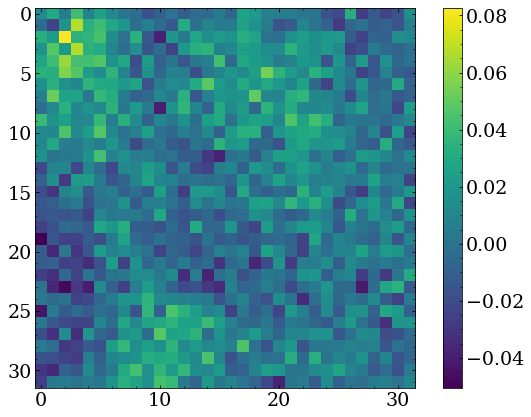

neuron A layer 1


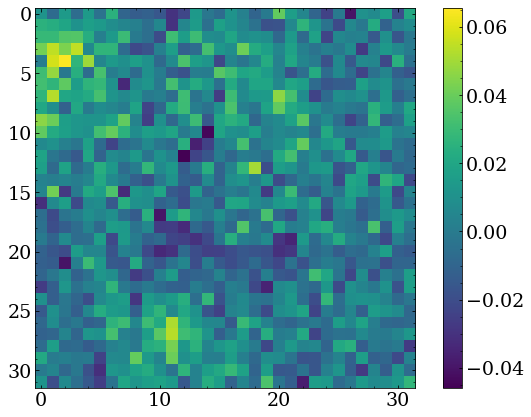

neuron A layer 2


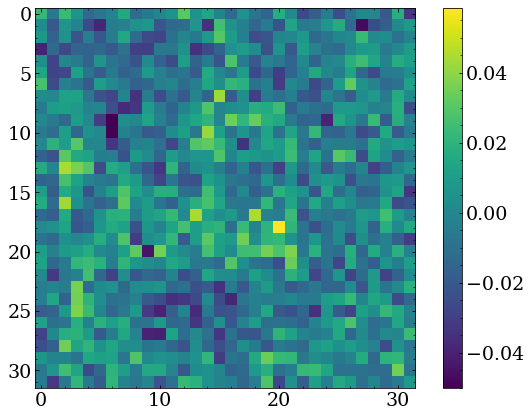

neuron A layer 3


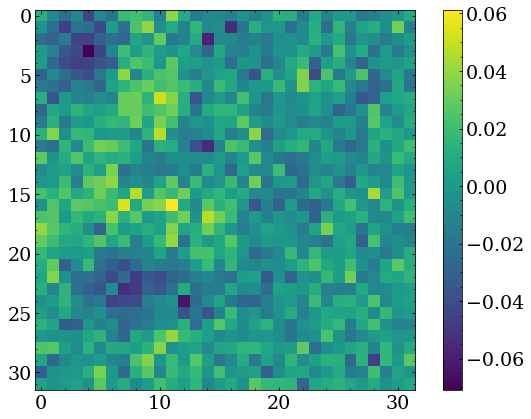

neuron A layer 4


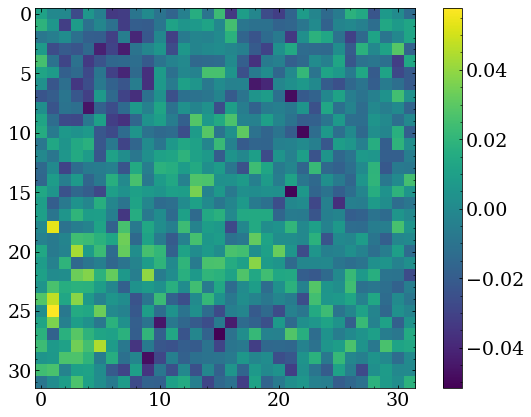

neuron B layer 0


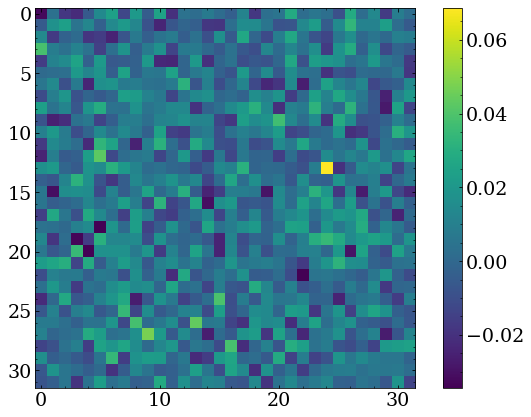

neuron B layer 1


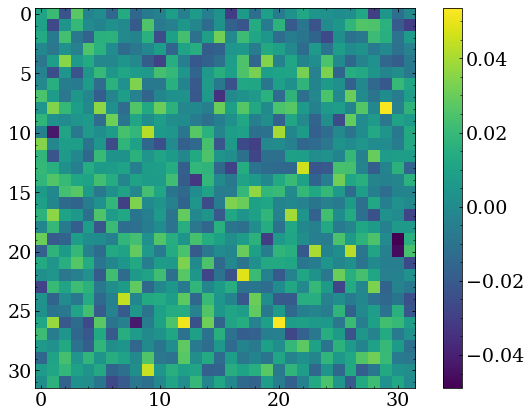

neuron B layer 2


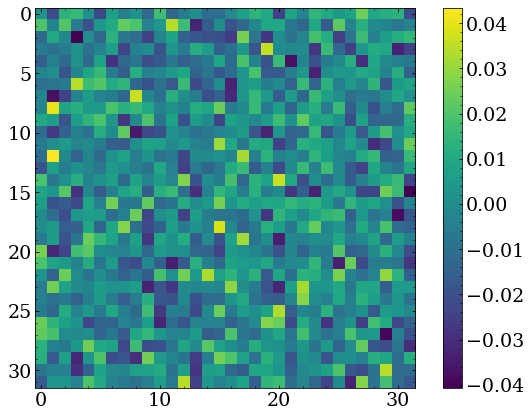

neuron B layer 3


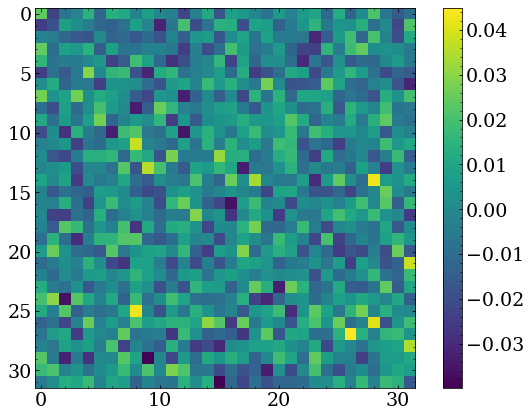

neuron B layer 4


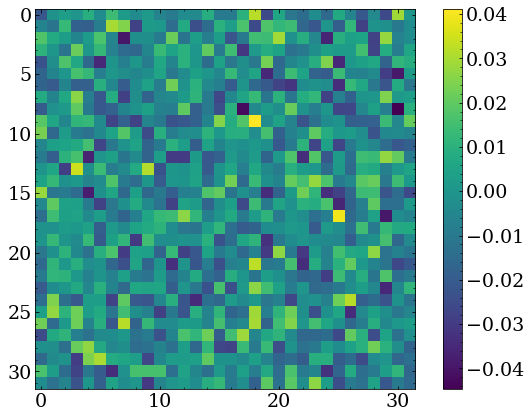

neuron C layer 0


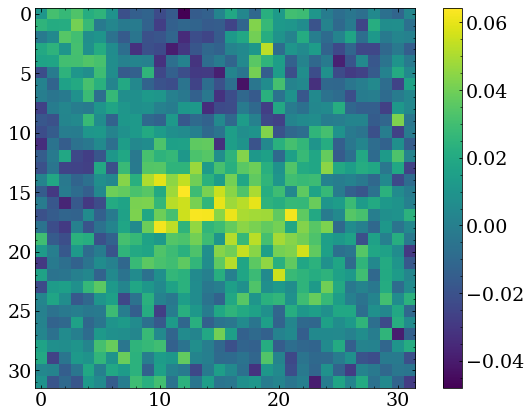

neuron C layer 1


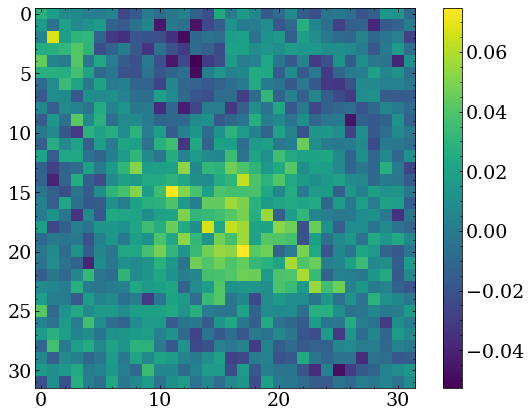

neuron C layer 2


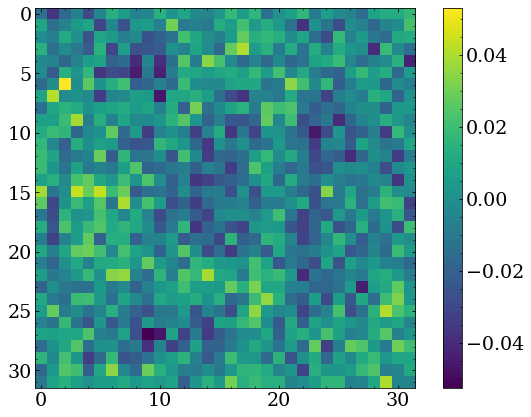

neuron C layer 3


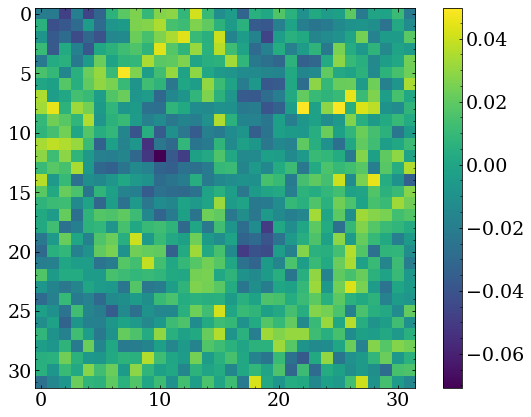

neuron C layer 4


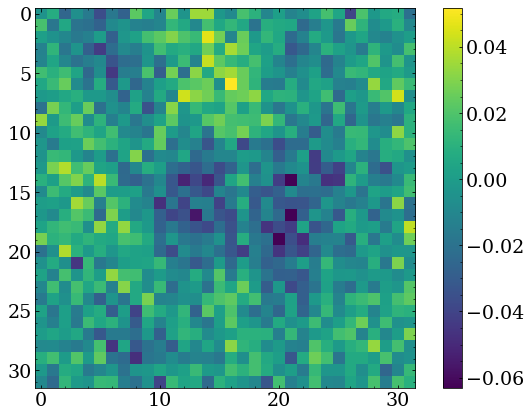

neuron D layer 0


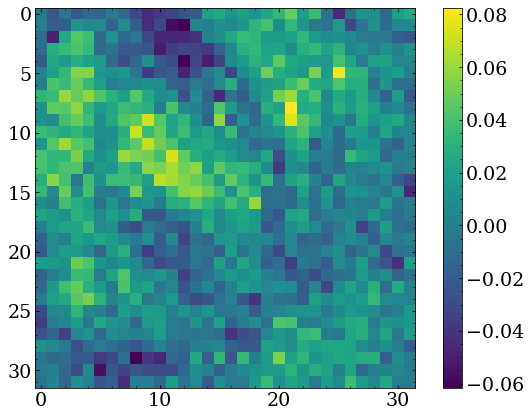

neuron D layer 1


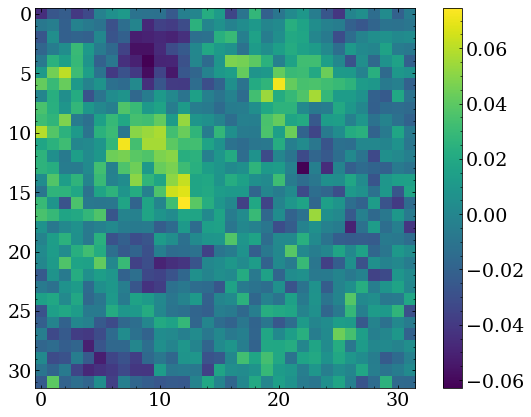

neuron D layer 2


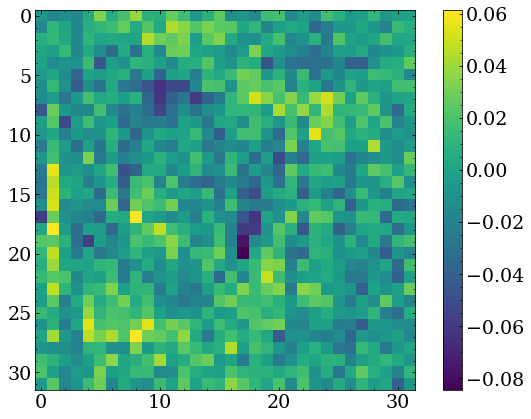

neuron D layer 3


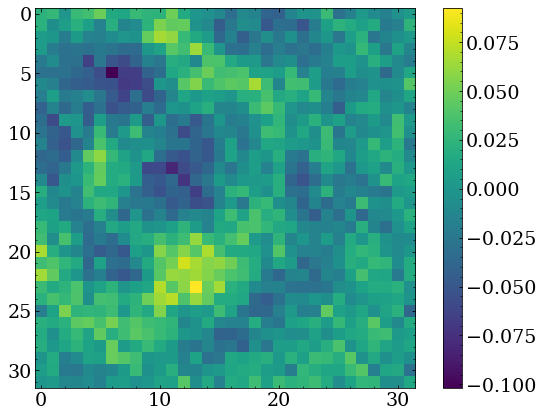

neuron D layer 4


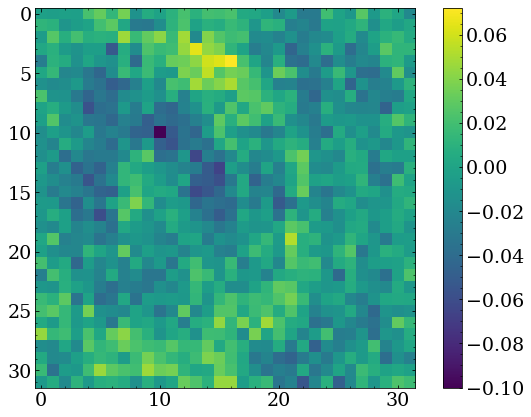

neuron E layer 0


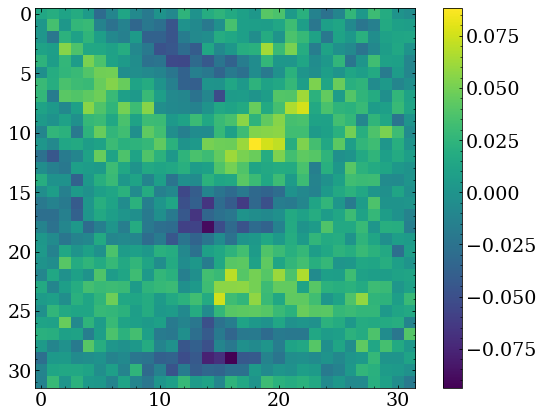

neuron E layer 1


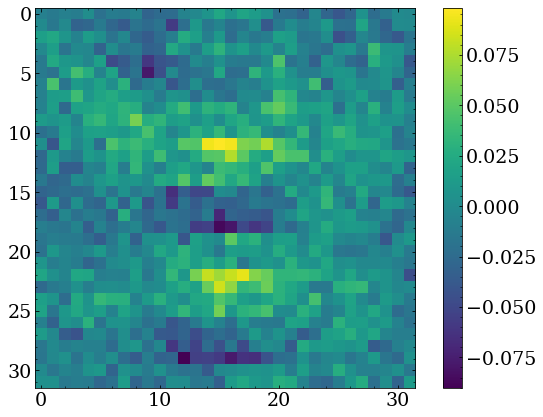

neuron E layer 2


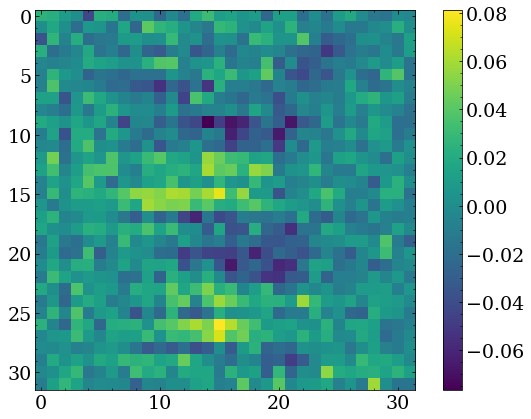

neuron E layer 3


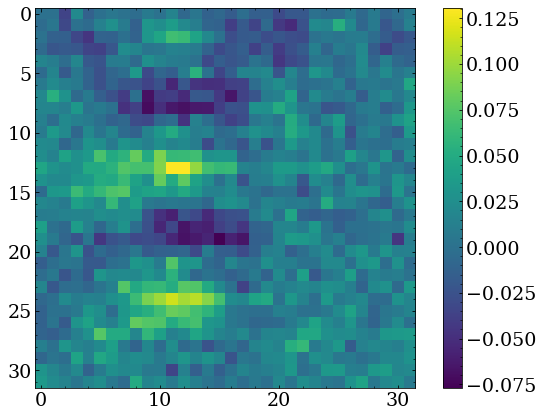

neuron E layer 4


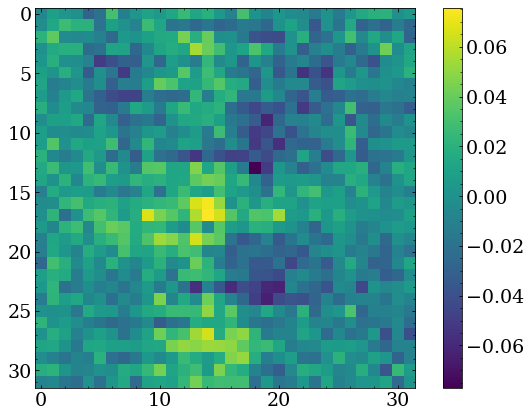

neuron F layer 0


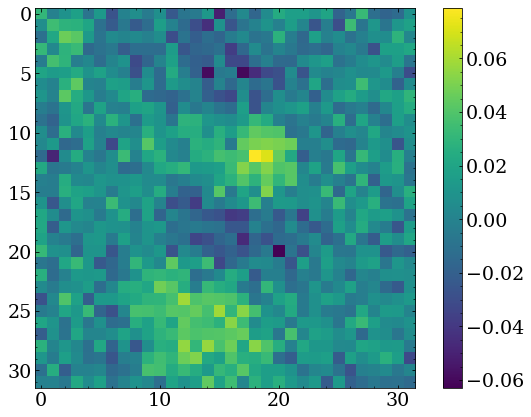

neuron F layer 1


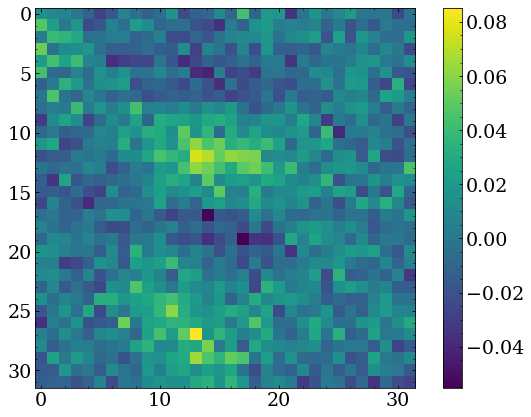

neuron F layer 2


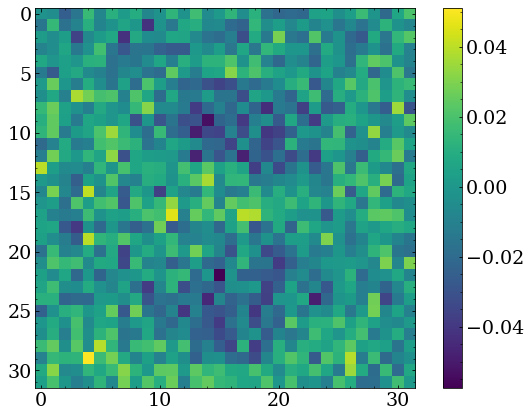

neuron F layer 3


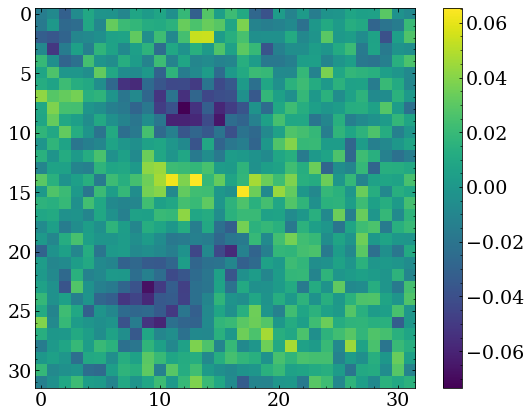

neuron F layer 4


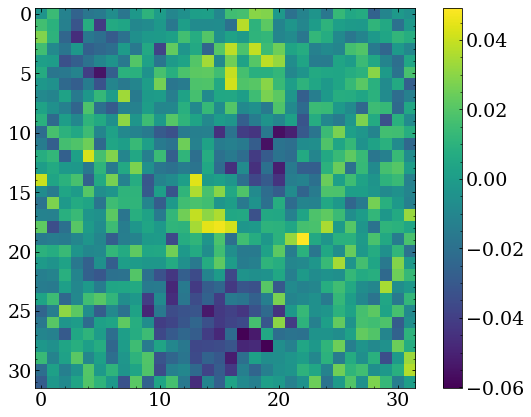

neuron G layer 0


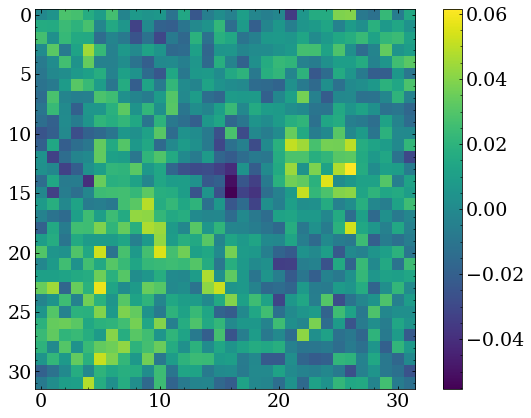

neuron G layer 1


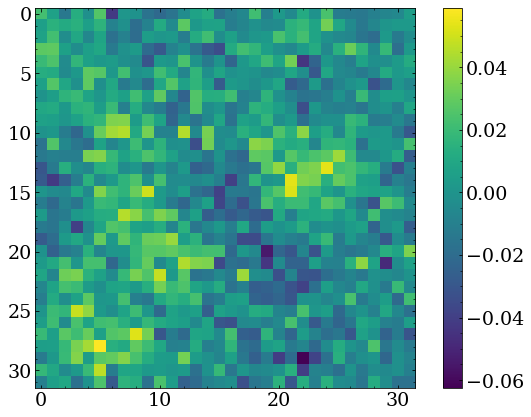

neuron G layer 2


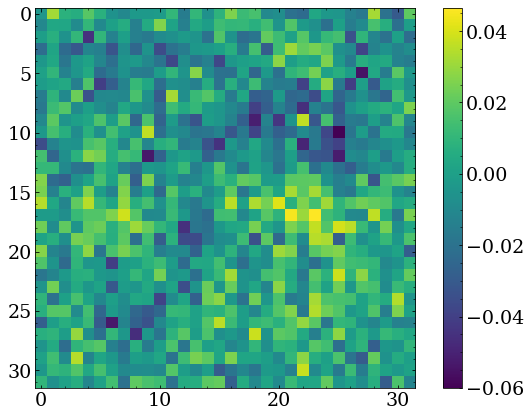

neuron G layer 3


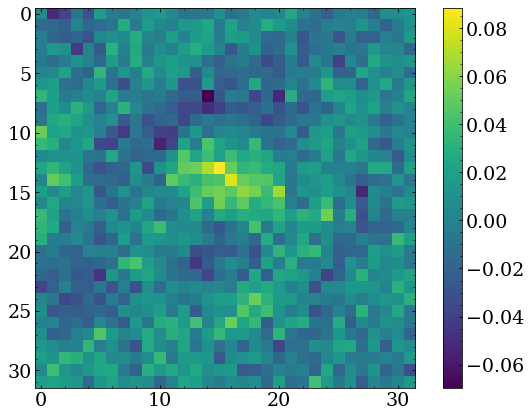

neuron G layer 4


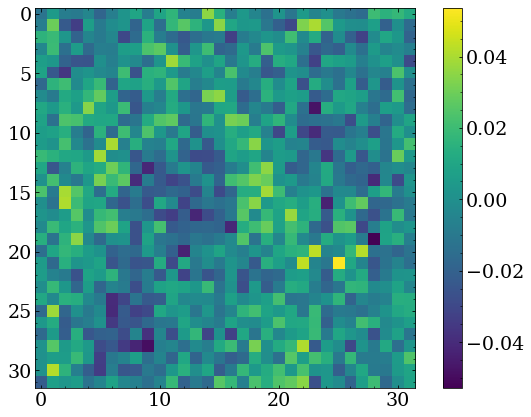

neuron H layer 0


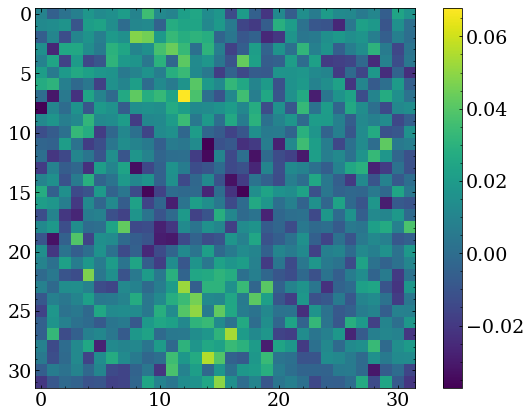

neuron H layer 1


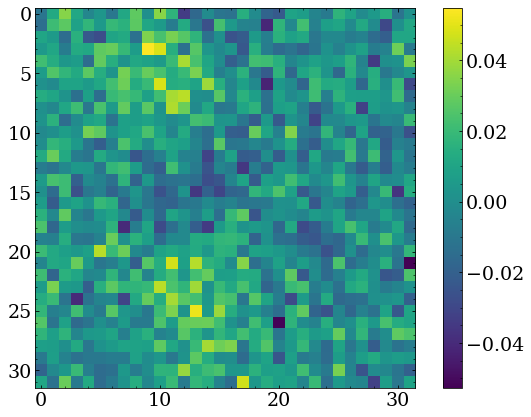

neuron H layer 2


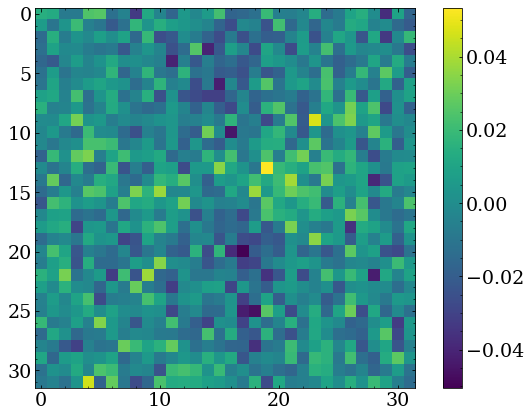

neuron H layer 3


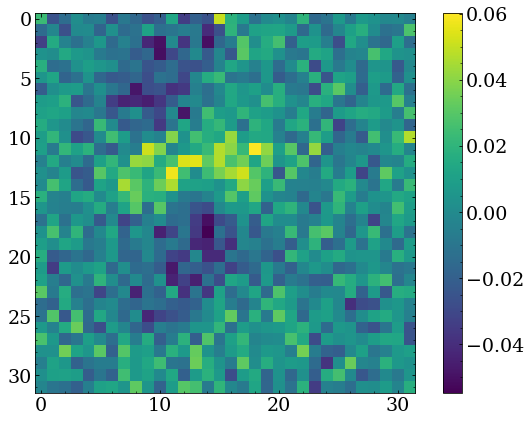

neuron H layer 4


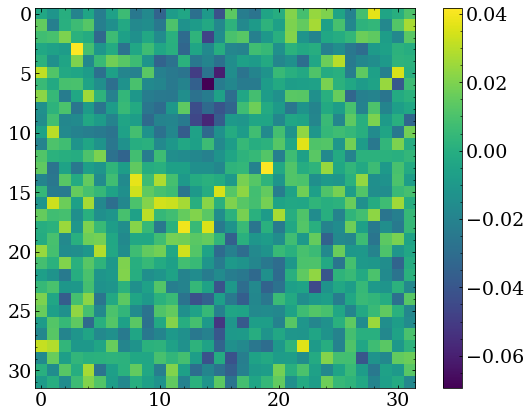

neuron I layer 0


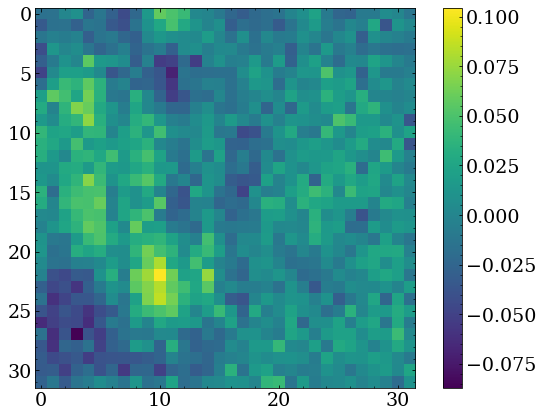

neuron I layer 1


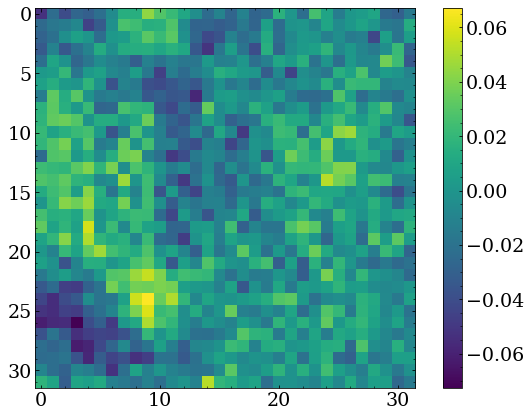

neuron I layer 2


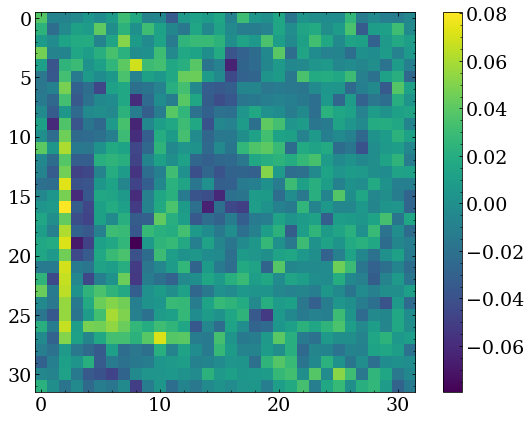

neuron I layer 3


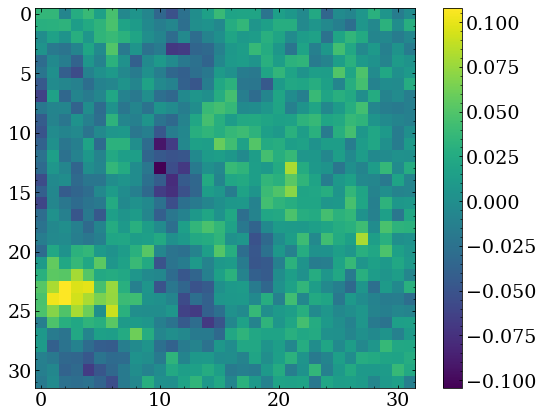

neuron I layer 4


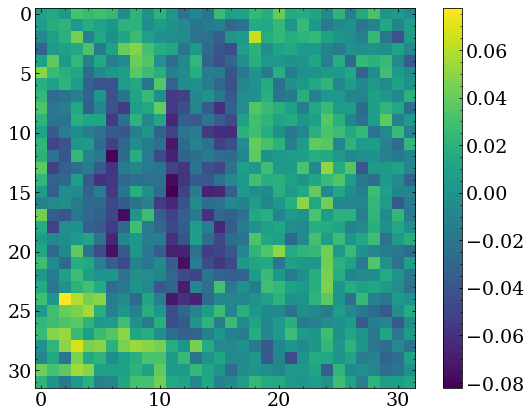

neuron J layer 0


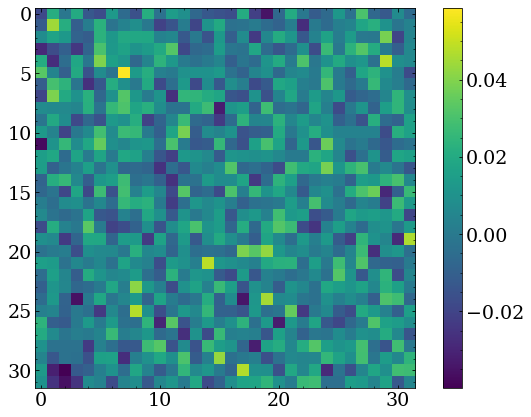

neuron J layer 1


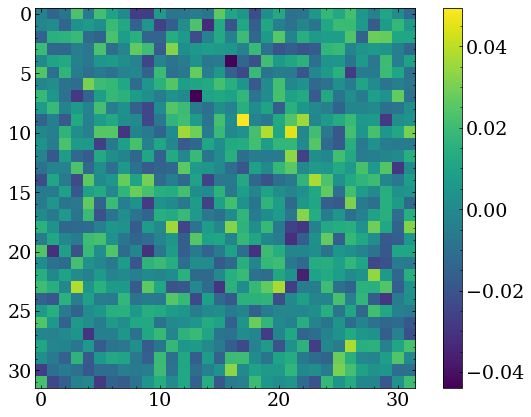

neuron J layer 2


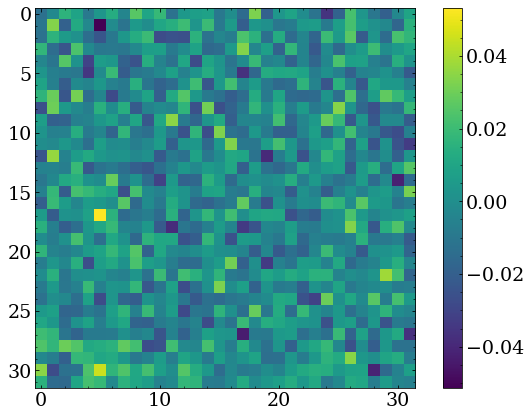

neuron J layer 3


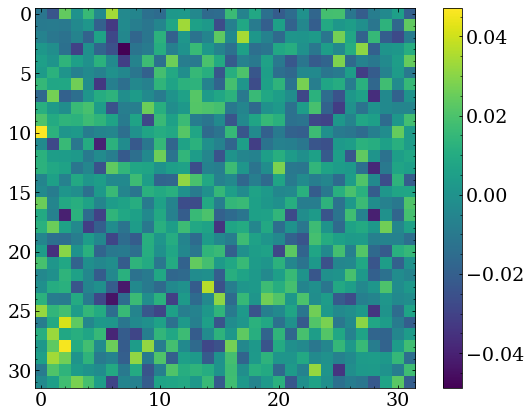

neuron J layer 4


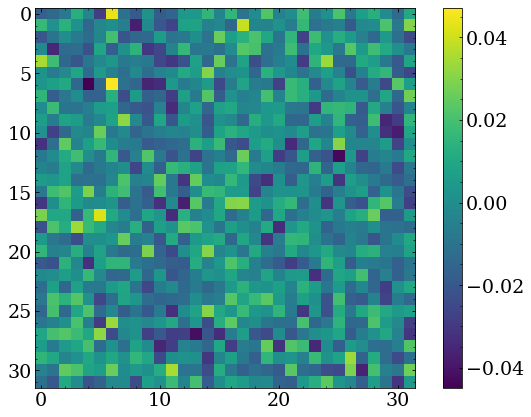

neuron K layer 0


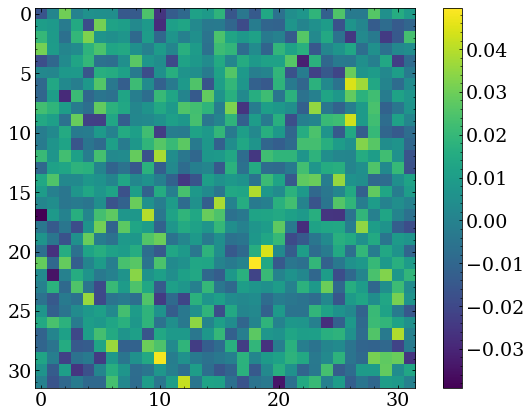

neuron K layer 1


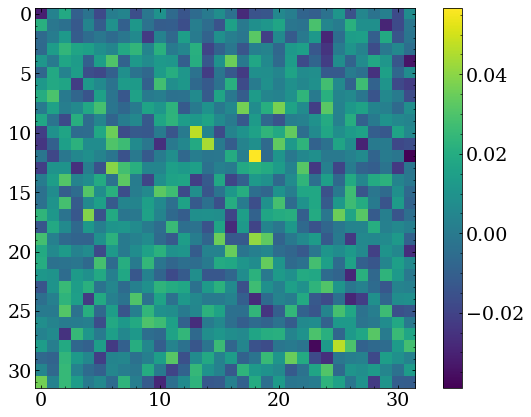

neuron K layer 2


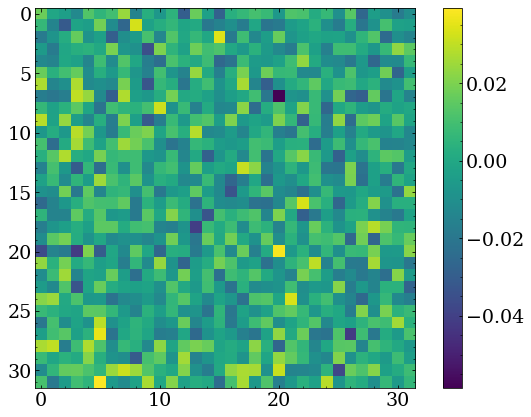

neuron K layer 3


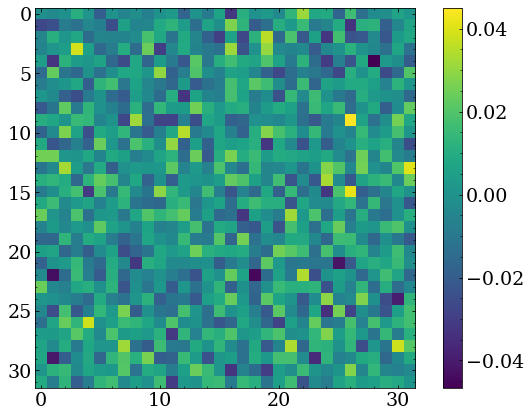

neuron K layer 4


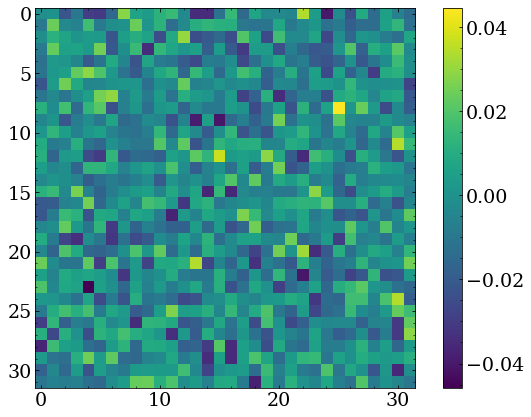

neuron L layer 0


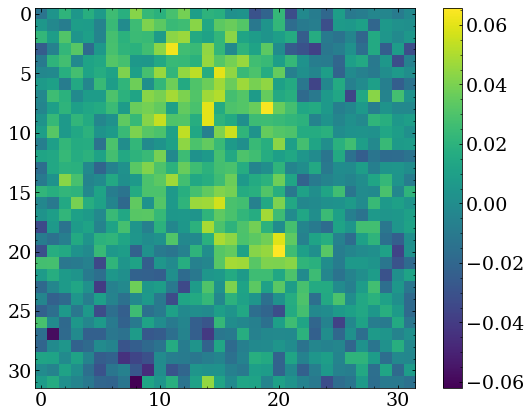

neuron L layer 1


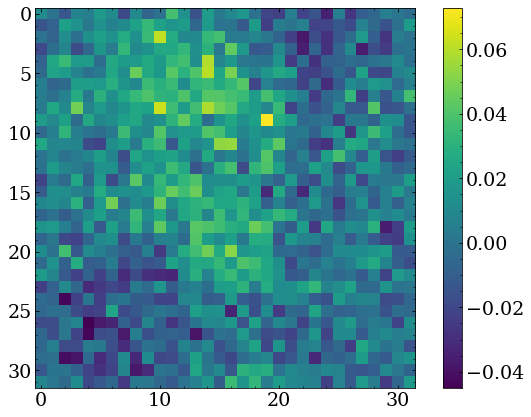

neuron L layer 2


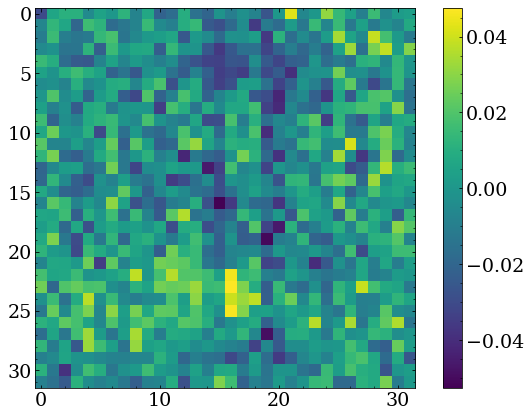

neuron L layer 3


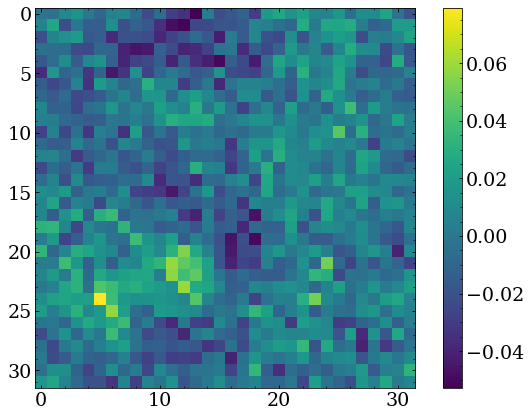

neuron L layer 4


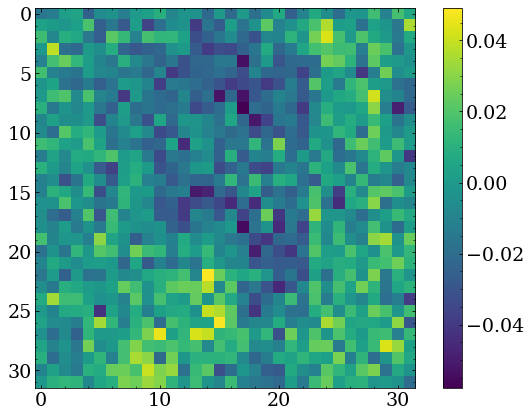

neuron M layer 0


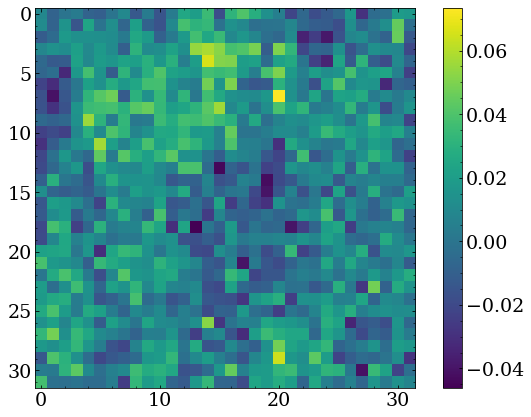

neuron M layer 1


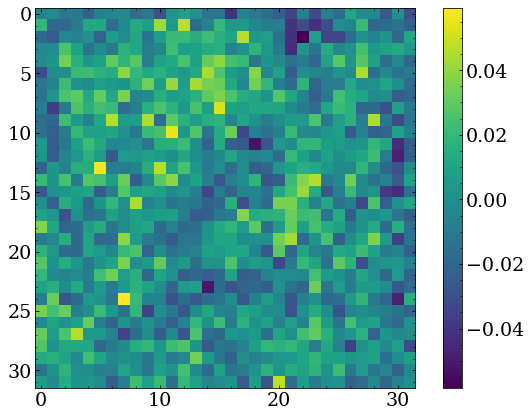

neuron M layer 2


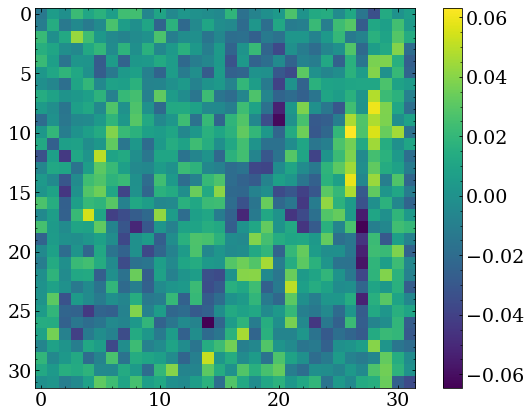

neuron M layer 3


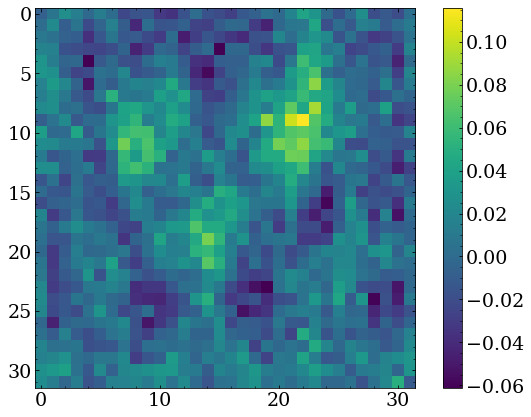

neuron M layer 4


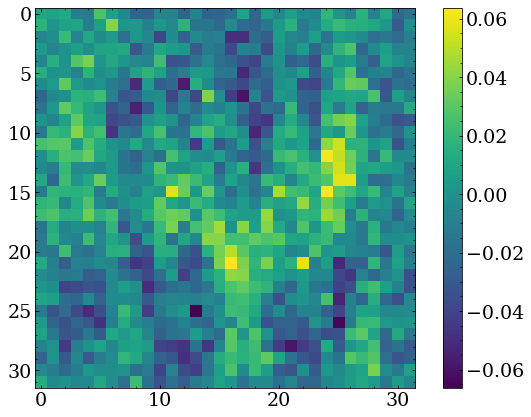

neuron N layer 0


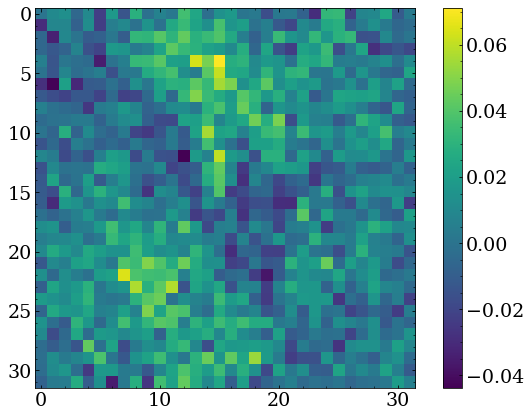

neuron N layer 1


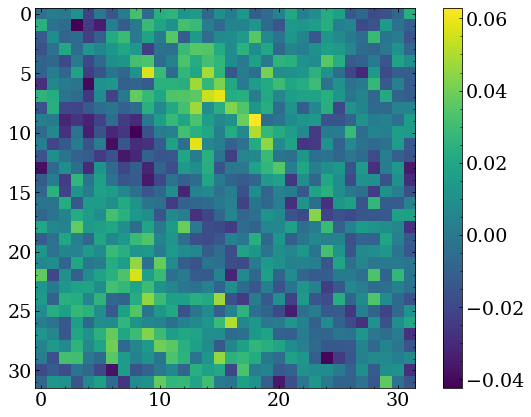

neuron N layer 2


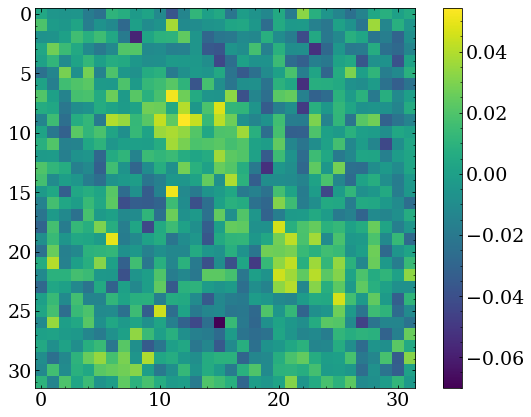

neuron N layer 3


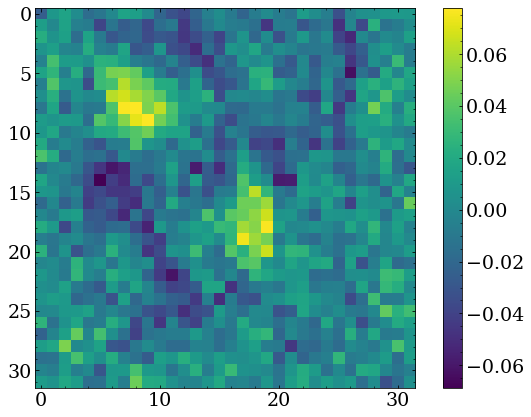

neuron N layer 4


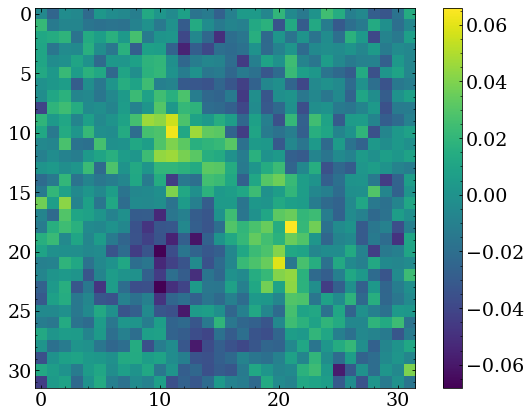

neuron O layer 0


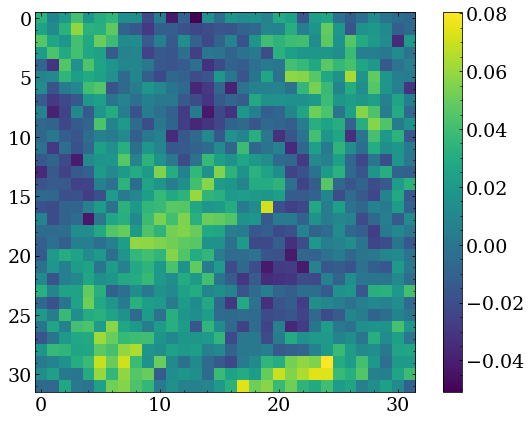

neuron O layer 1


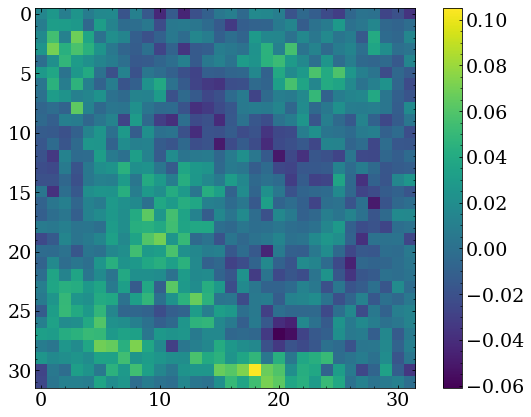

neuron O layer 2


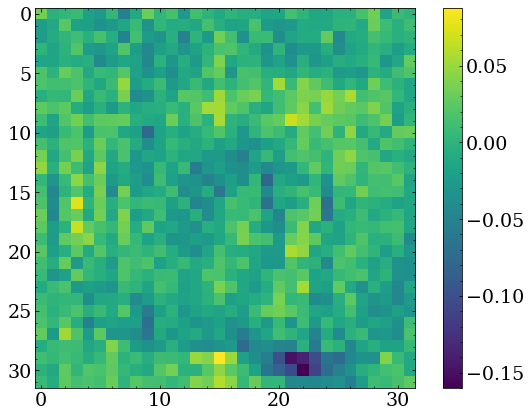

neuron O layer 3


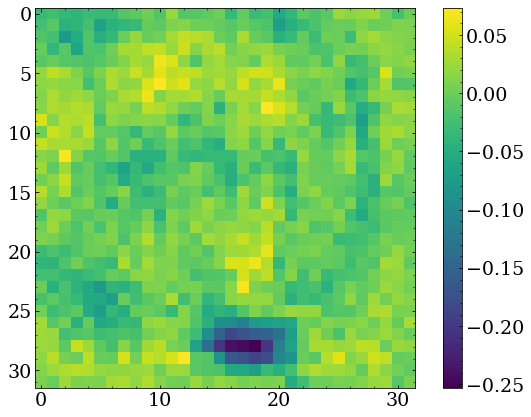

neuron O layer 4


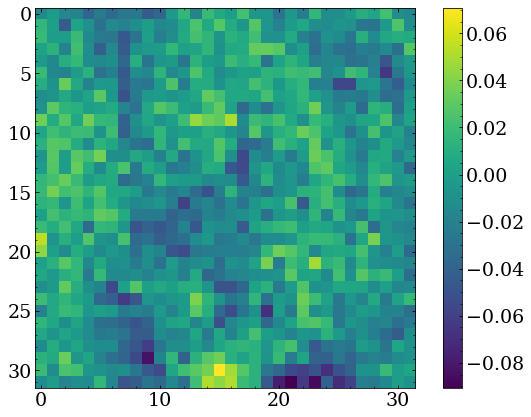

neuron P layer 0


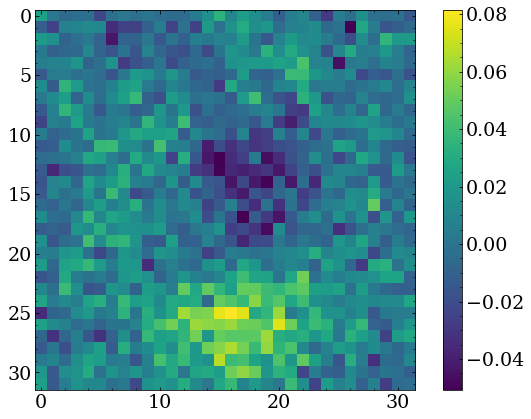

neuron P layer 1


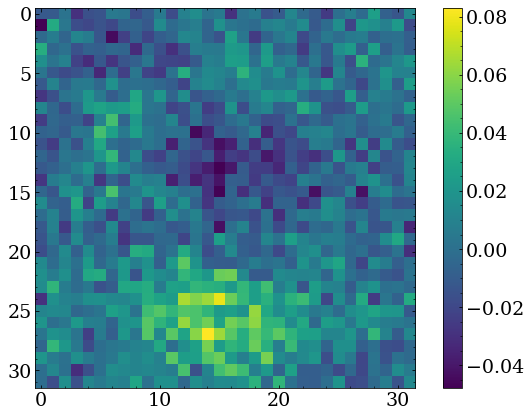

neuron P layer 2


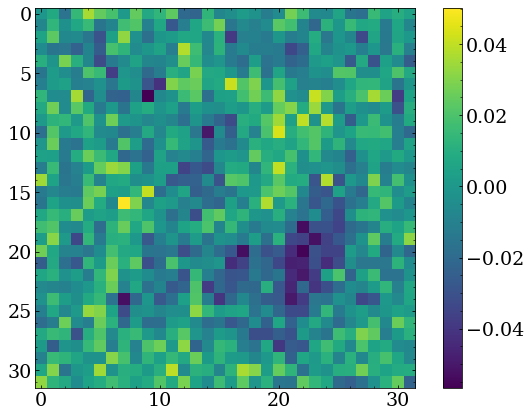

neuron P layer 3


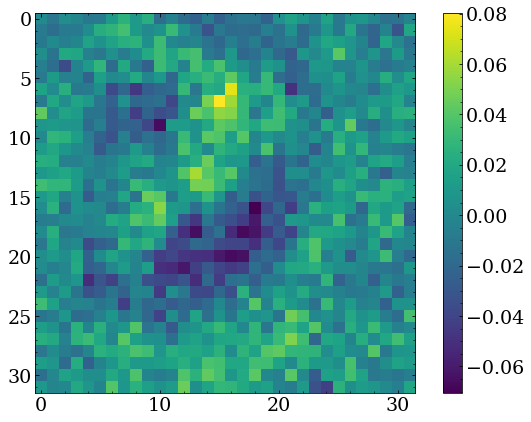

neuron P layer 4


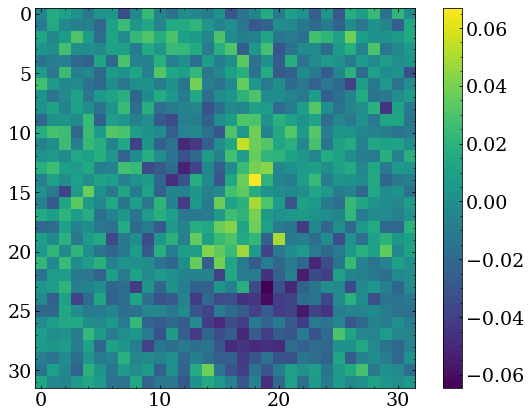

neuron Q layer 0


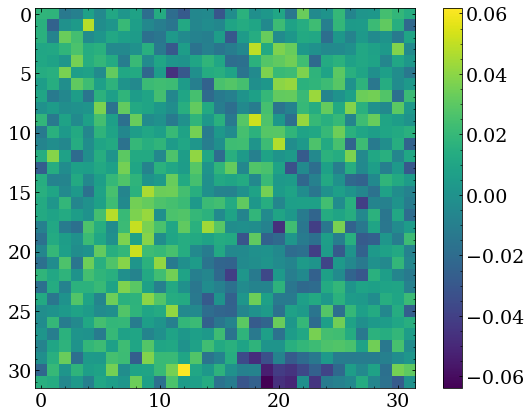

neuron Q layer 1


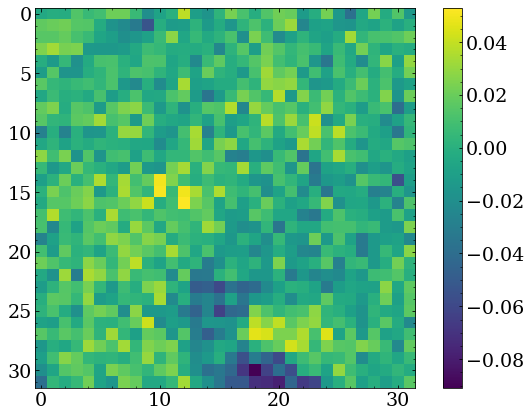

neuron Q layer 2


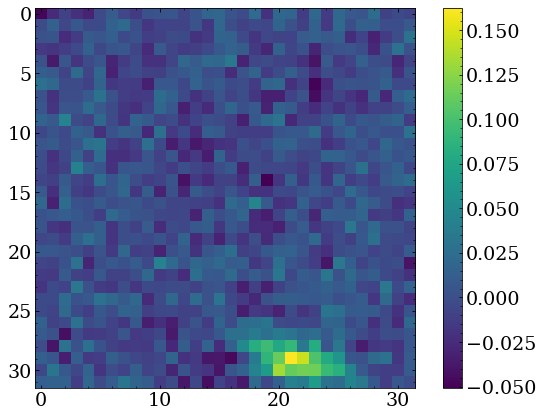

neuron Q layer 3


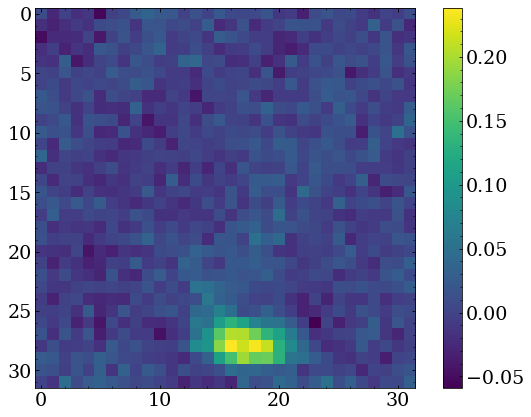

neuron Q layer 4


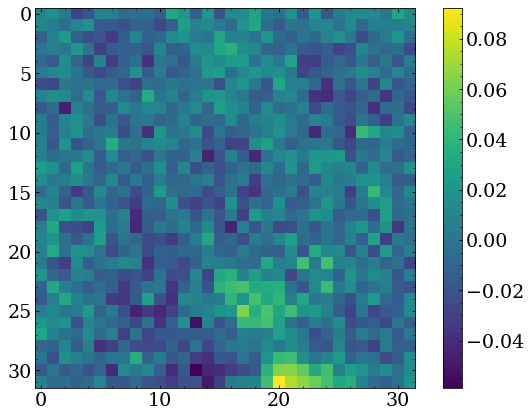

neuron R layer 0


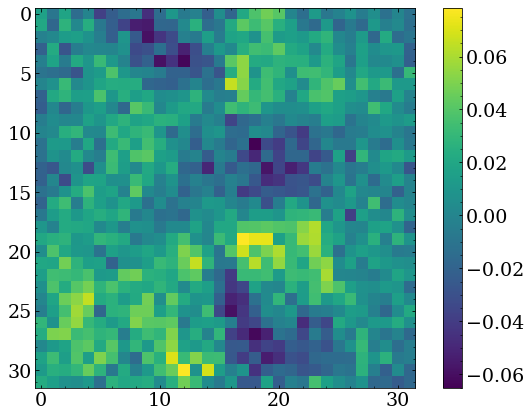

neuron R layer 1


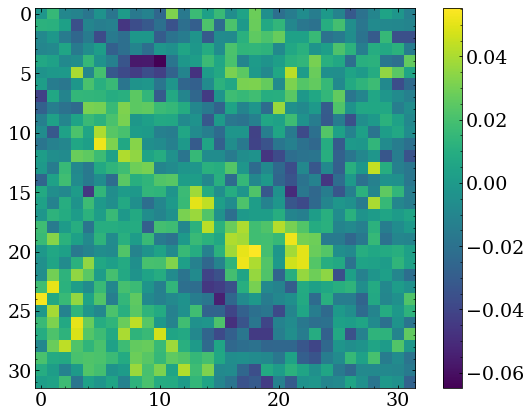

neuron R layer 2


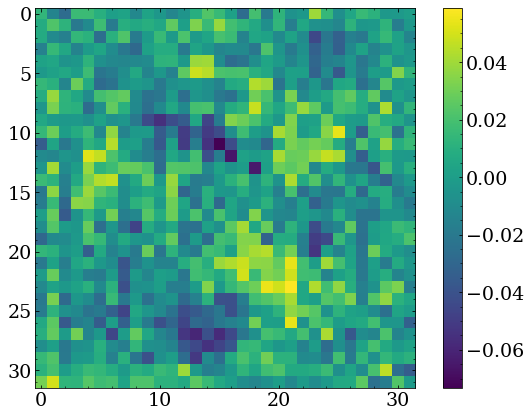

neuron R layer 3


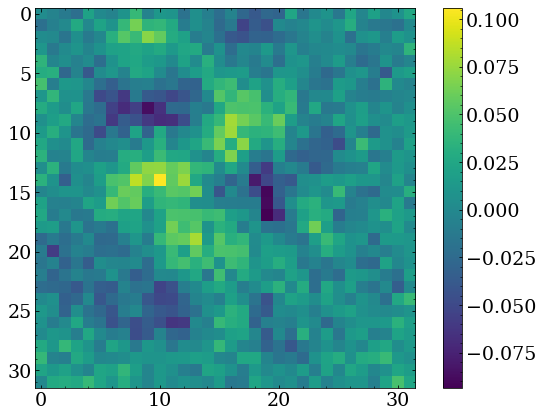

neuron R layer 4


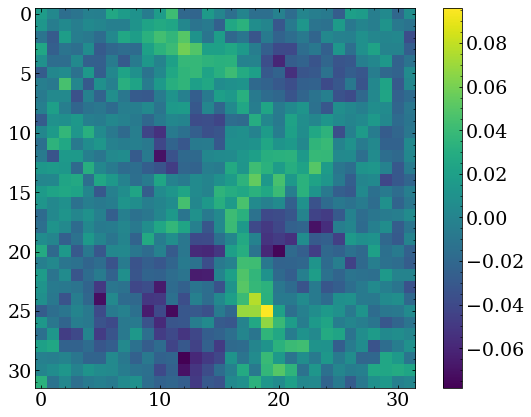

neuron S layer 0


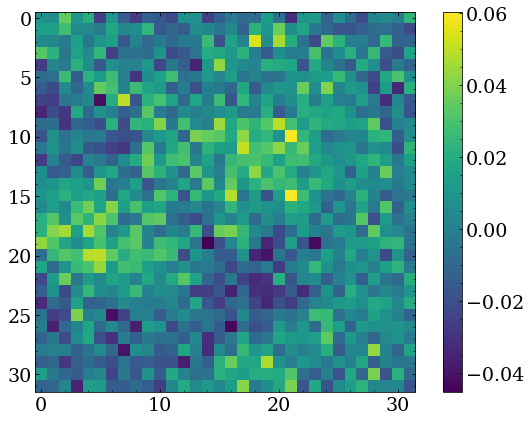

neuron S layer 1


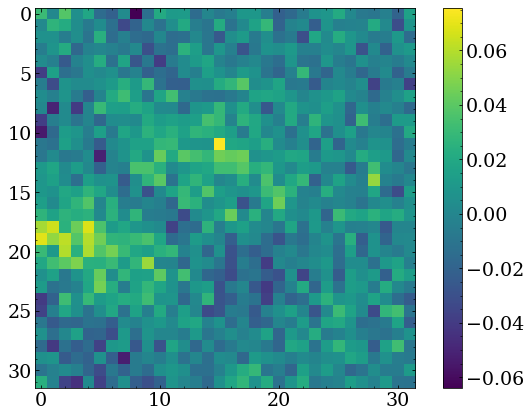

neuron S layer 2


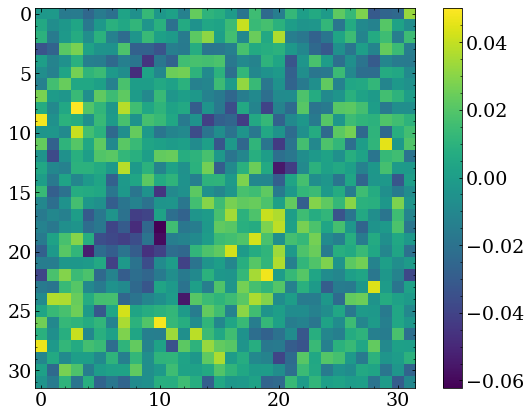

neuron S layer 3


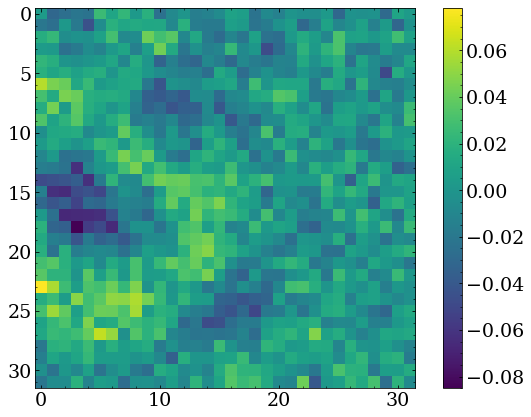

neuron S layer 4


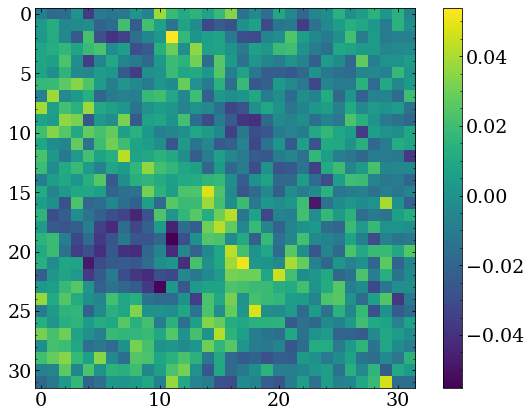

neuron T layer 0


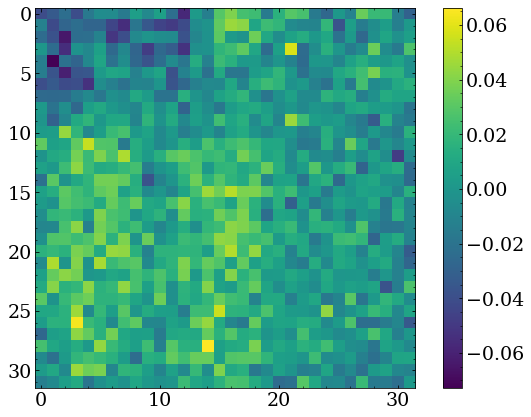

neuron T layer 1


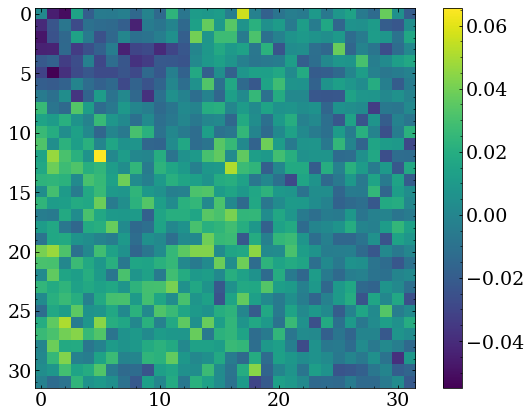

neuron T layer 2


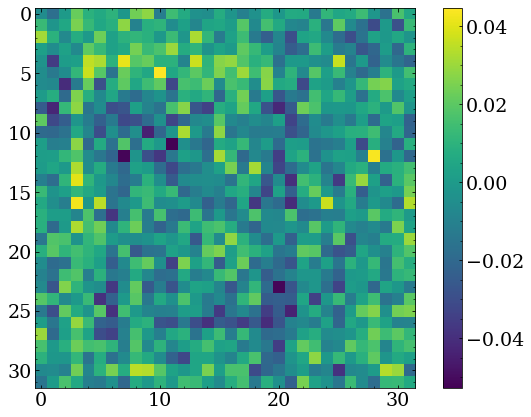

neuron T layer 3


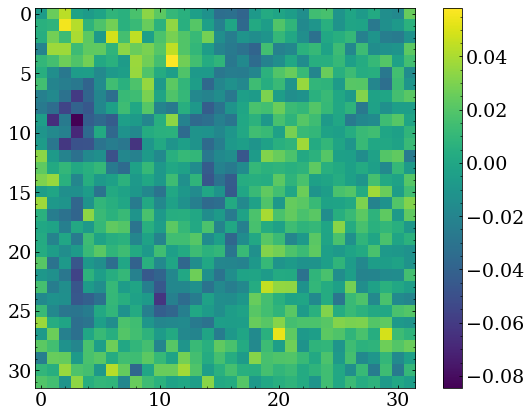

neuron T layer 4


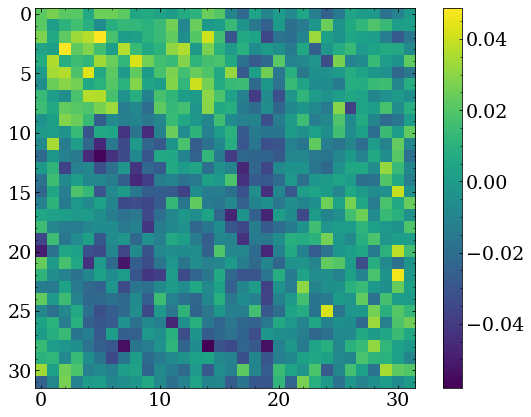

neuron U layer 0


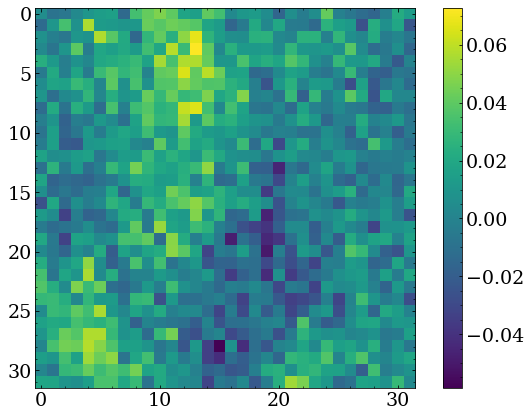

neuron U layer 1


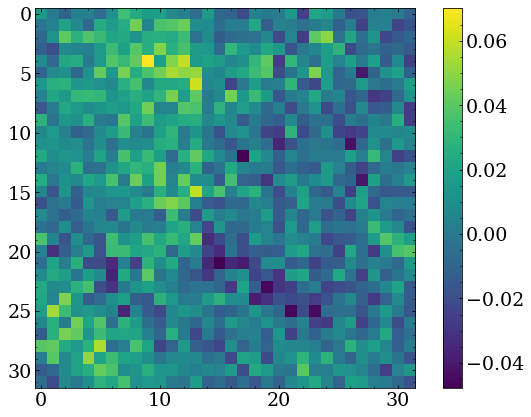

neuron U layer 2


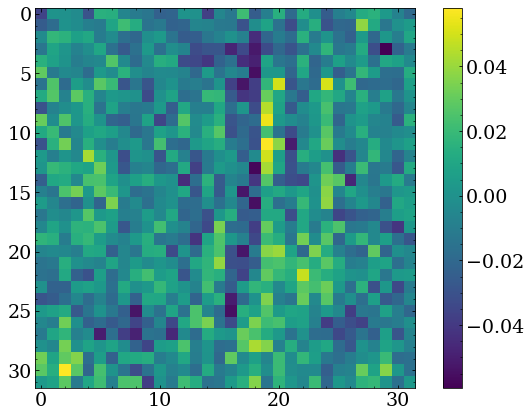

neuron U layer 3


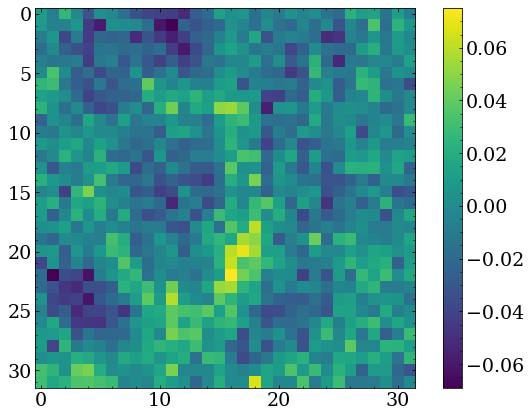

neuron U layer 4


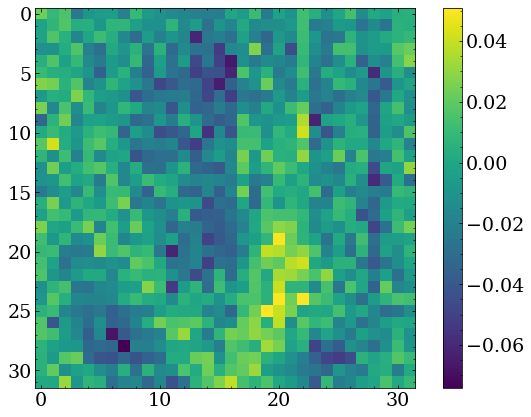

neuron V layer 0


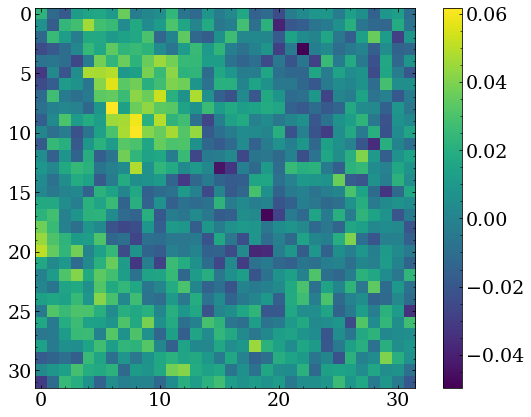

neuron V layer 1


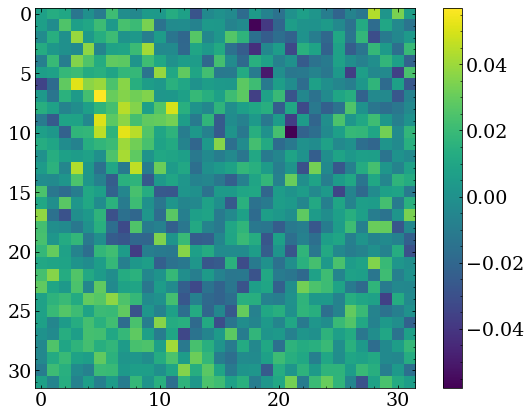

neuron V layer 2


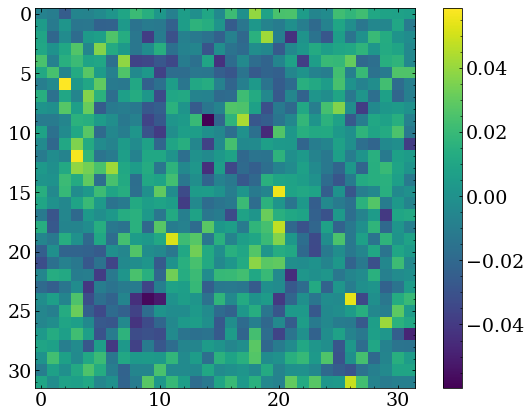

neuron V layer 3


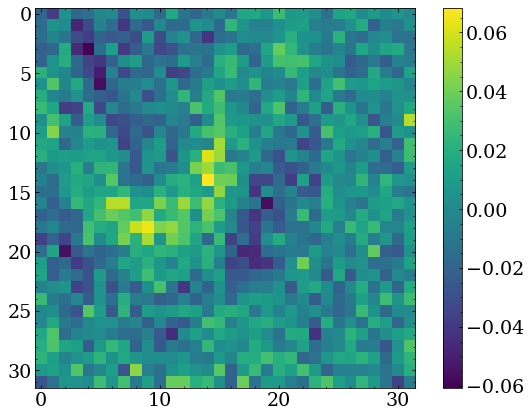

neuron V layer 4


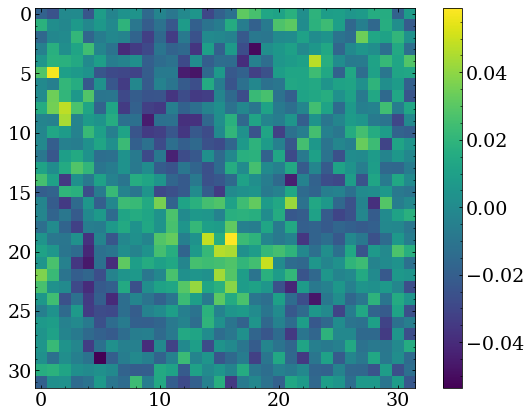

neuron W layer 0


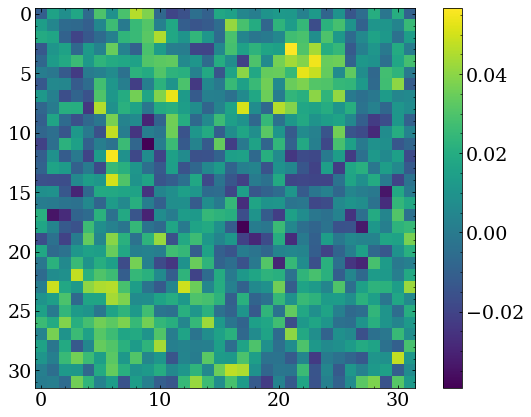

neuron W layer 1


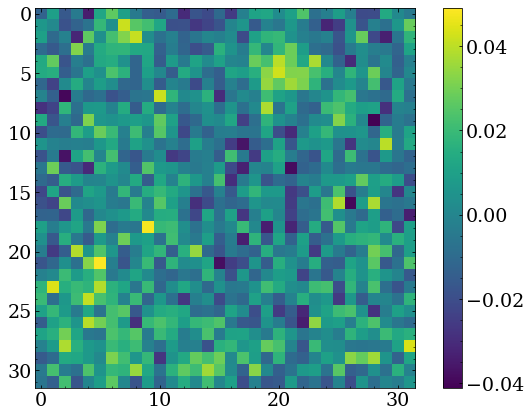

neuron W layer 2


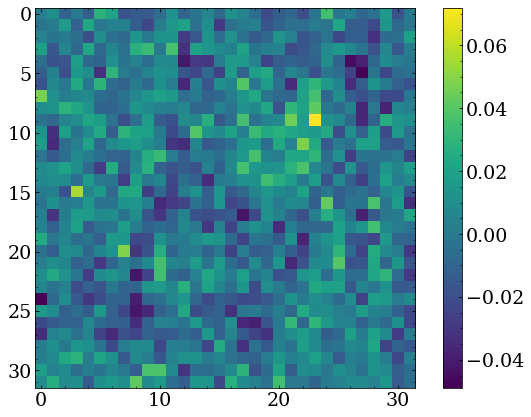

neuron W layer 3


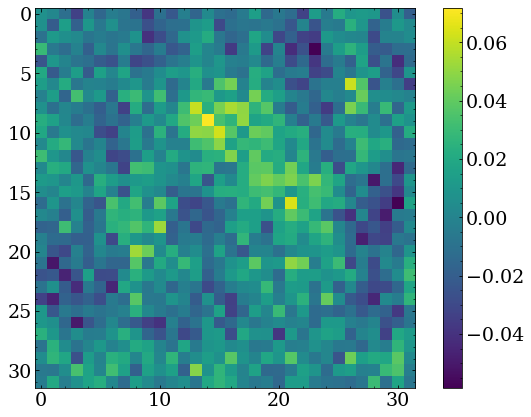

neuron W layer 4


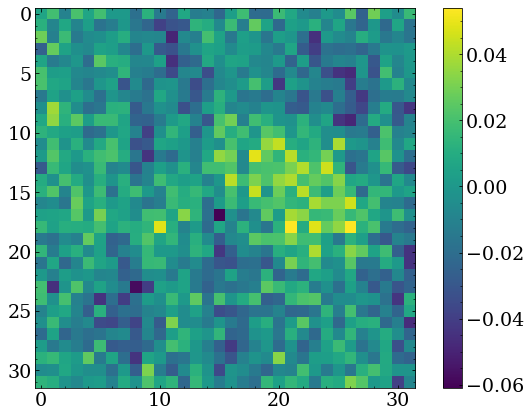

neuron X layer 0


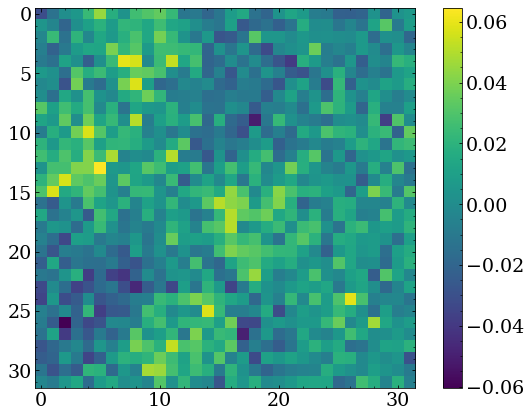

neuron X layer 1


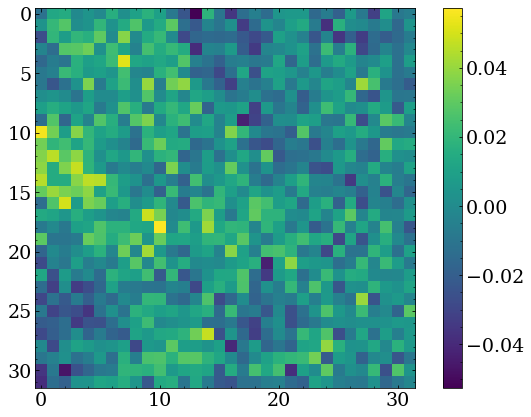

neuron X layer 2


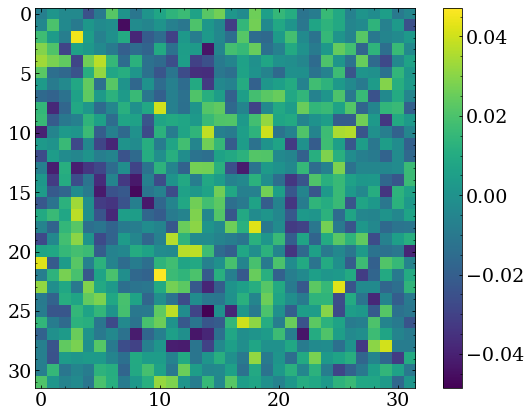

neuron X layer 3


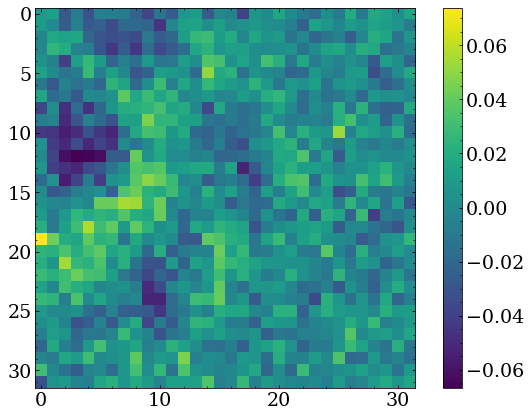

neuron X layer 4


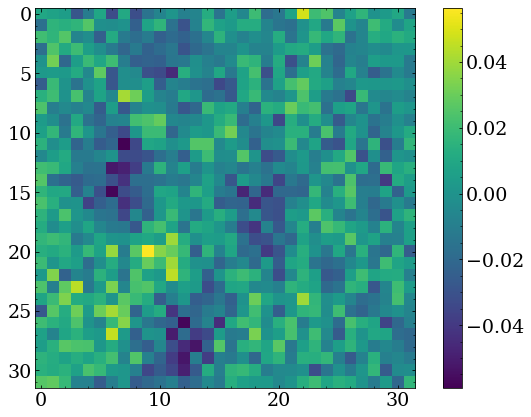

neuron Y layer 0


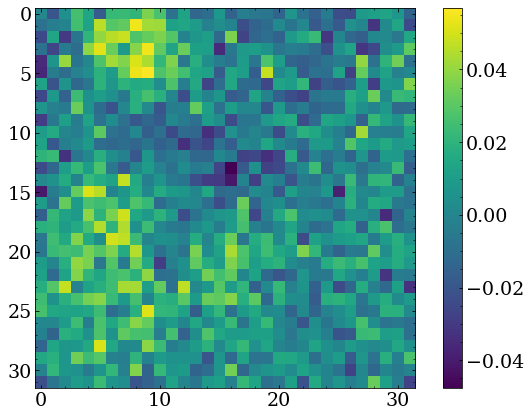

neuron Y layer 1


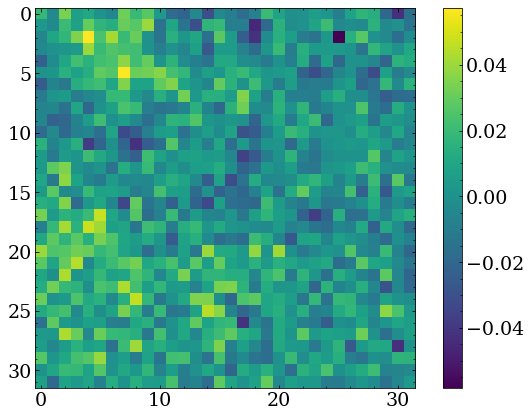

neuron Y layer 2


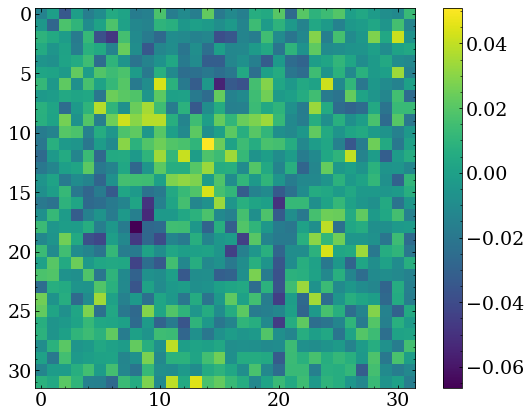

neuron Y layer 3


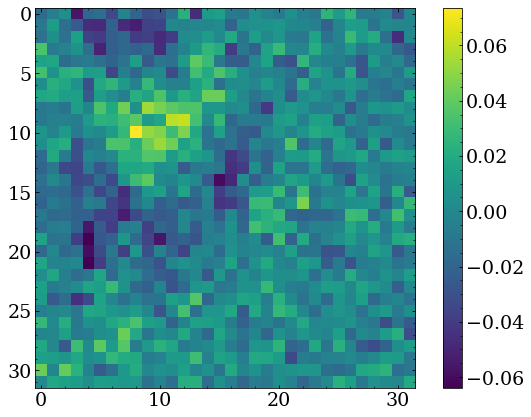

neuron Y layer 4


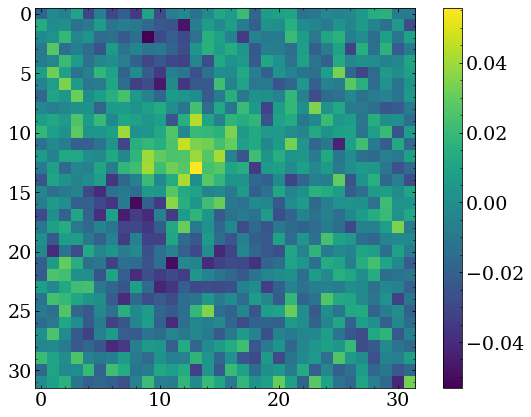

In [21]:
for i,c in enumerate(range(ord('A'),ord('Z'))):
    for j in range(np.prod(conv_outs[-1])):
        print('neuron',chr(c),'layer',j)
        plt.imshow(s.parts[0].layer[0].weights[i].reshape(input_shape+conv_outs[-1])[:,:,j])
        plt.colorbar()
        plt.show()
        plt.close()

Conv :: [(32, 32)] -> [(32, 32, 5)]
(5, 25)
conv kernel 0


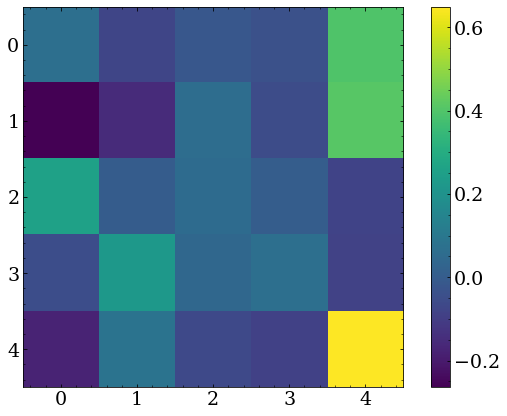

conv kernel 1


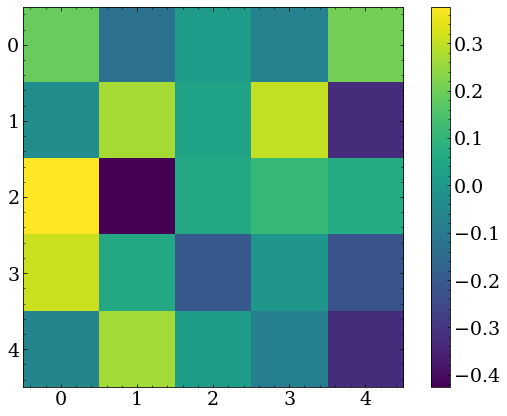

conv kernel 2


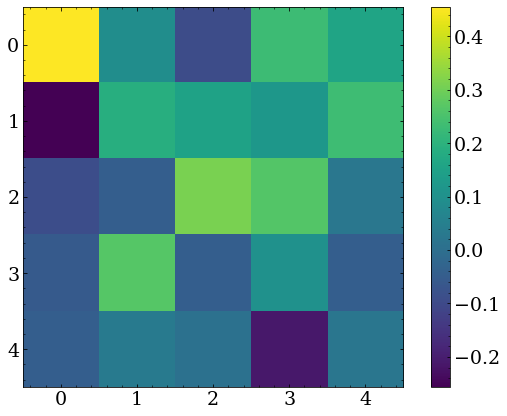

conv kernel 3


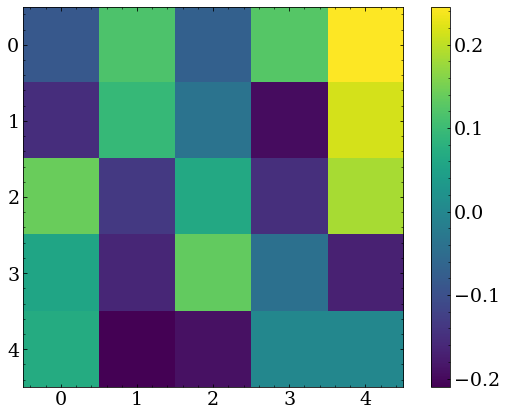

conv kernel 4


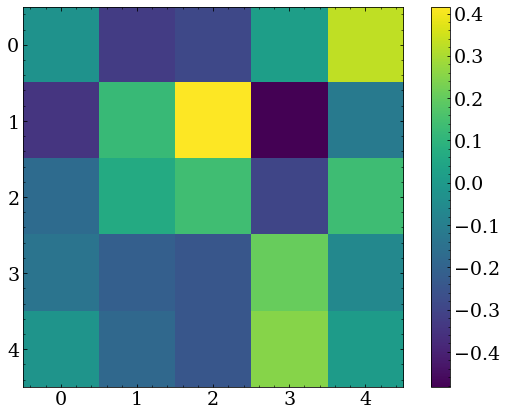

In [22]:
for i in [-2]:
    conv_inst = s.parts[i]
    print(conv_inst)
    conv_net = conv_inst.layer[0]
    print(conv_net.weights.shape)
    shape = conv_outs[-i]+conv_kernels[i]
    weights = conv_net.weights.reshape(shape)
    for j in range(conv_outs[i][0]):
        print('conv kernel',j)
        plt.imshow(weights[j])
        plt.colorbar()
        plt.show()
        plt.close()